Demo video (Prajwala)
https://nyu.zoom.us/rec/play/z6Umj6gtJZ7lMxTKkWxXZDUs22N1yhFs7rLREQAIuVjuaqJvyz9vTduG4RxTdZX5qjuRcPJS_FInygaH.n3MG9vJ7MN9k7Fb7

# Momentum in Optimization

## Helpful resources:
- Blog post with theoretical background and relating the concept to applications: https://distill.pub/2017/momentum/


In [ ]:
!pip install d2l==0.14.4


     |████████████████████████████████| 61kB 3.0MB/s 


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch

from d2l import torch as d2l

# Momentum

We have learned what happens when performing stochastic gradient descent, i.e., when performing optimization where only a noisy variant of the gradient is available. For noisy gradients, we need to be extra cautious when it comes to choosing the learning rate in the face of noise. If we decrease it too rapidly, convergence stalls. If we are too lenient, we fail to converge to a good enough solution since noise keeps on driving us away from optimality.

In this demo, we will explore more effective optimization algorithms, especially for certain types of optimization problems that are common in practice.


### Leaky Averages

Minibatch SGD is a means for accelerating computation. It also has the nice side-effect that averaging gradients reduces the amount of variance. The minibatch SGD can be calculated by:

$$\mathbf{g}_{t, t-1} = \partial_{\mathbf{w}} \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} f(\mathbf{x}_{i}, \mathbf{w}_{t-1}) = \frac{1}{|\mathcal{B}_t|} \sum_{i \in \mathcal{B}_t} \mathbf{h}_{i, t-1}.
$$

To keep the notation simple, here we use $\mathbf{h}_{i, t-1} = \partial_{\mathbf{w}} f(\mathbf{x}_i, \mathbf{w}_{t-1})$ as the SGD for sample $i$ using the weights updated at time $t-1$.
It would be nice if we could benefit from the effect of variance reduction even beyond averaging gradients on a mini-batch. One option to accomplish this task is to replace the gradient computation by a "leaky average":

$$\mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}$$

for some $\beta \in (0, 1)$. This effectively replaces the instantaneous gradient by one that's been averaged over multiple *past* gradients. $\mathbf{v}$ is called *momentum*. It accumulates past gradients similar to how a heavy ball rolling down the objective function landscape integrates over past forces. To see what is happening in more detail let us expand $\mathbf{v}_t$ recursively into

$$\begin{aligned}
\mathbf{v}_t = \beta^2 \mathbf{v}_{t-2} + \beta \mathbf{g}_{t-1, t-2} + \mathbf{g}_{t, t-1}
= \ldots, = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}.
\end{aligned}$$

Large $\beta$ amounts to a long-range average, whereas small $\beta$ amounts to only a slight correction relative to a gradient method. The new gradient replacement no longer points into the direction of steepest descent on a particular instance any longer but rather in the direction of a weighted average of past gradients. This allows us to realize most of the benefits of averaging over a batch without the cost of actually computing the gradients on it. We will revisit this averaging procedure in more detail later.

The above reasoning formed the basis for what is now known as *accelerated* gradient methods, such as gradients with momentum. They enjoy the additional benefit of being much more effective in cases where the optimization problem is ill-conditioned (i.e., where there are some directions where progress is much slower than in others, resembling a narrow canyon). Furthermore, they allow us to average over subsequent gradients to obtain more stable directions of descent. Indeed, the aspect of acceleration even for noise-free convex problems is one of the key reasons why momentum works and why it works so well.

As one would expect, due to its efficacy momentum is a well-studied subject in optimization for deep learning and beyond. See e.g., the beautiful [expository article](https://distill.pub/2017/momentum/) by `Goh.2017` for an in-depth analysis and interactive animation. It was proposed by `Polyak.1964`. `Nesterov.2018` has a detailed theoretical discussion in the context of convex optimization. Momentum in deep learning has been known to be beneficial for a long time. See e.g., the discussion by `Sutskever.Martens.Dahl.ea.2013` for details.

### An Ill-conditioned Problem

To get a better understanding of the geometric properties of the momentum method we revisit gradient descent, with a significantly less pleasant objective function. We use a distorted ellipsoid objective, stretching it out in the $x_1$ direction via

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

$f$ has its minimum at $(0, 0)$. This function is *very* flat in the direction of $x_1$. Let us see what happens when we perform gradient descent as before on this new function. We pick a learning rate of $0.4$.


In [ ]:
def train_2d(optimizer, steps=20):
    """
    Optimize a 2D objective function with a customized trainer.
    """
    # s1 and s2 are internal state variables and will
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2, s1, s2 = optimizer(x1, x2, s1, s2)
        results.append((x1, x2))
    return results

def plot_trace_2d(f, results):
    """
    Show the trace of 2D variables during optimization.
    """
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1),
                          np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

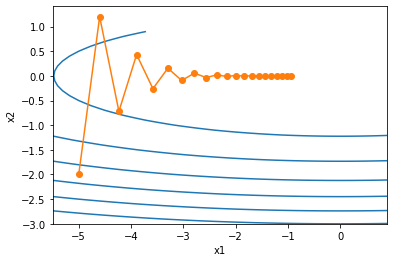

In [ ]:
eta = 0.4
def f(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_optimizer(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

plot_trace_2d(f, train_2d(gd_optimizer))

By construction, the gradient in the $x_2$ direction is *much* higher and changes much more rapidly than in the horizontal $x_1$ direction. Thus we are stuck between two undesirable choices: if we pick a small learning rate we ensure that the solution does not diverge in the $x_2$ direction but we are saddled with slow convergence in the $x_1$ direction. Conversely, with a large learning rate we progress rapidly in the $x_1$ direction but diverge in $x_2$. The example below illustrates what happens even after a slight increase in learning rate from $0.4$ to $0.6$. Convergence in the $x_1$ direction improves but the overall solution quality is much worse.


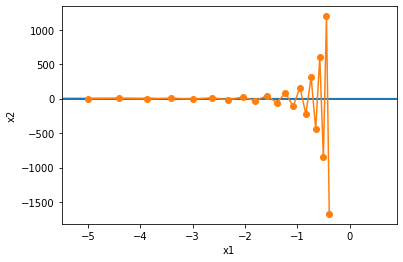

In [ ]:
eta = 0.6
plot_trace_2d(f, train_2d(gd_optimizer))

### The Momentum Method

The momentum method allows us to solve the gradient descent problem described
above. Looking at the optimization trace above we might intuit that averaging gradients over the past would work well. After all, in the $x_1$ direction this will aggregate well-aligned gradients, thus increasing the distance we cover with every step. Conversely, in the $x_2$ direction where gradients oscillate, an aggregate gradient will reduce step size due to oscillations that cancel each other out.
Using $\mathbf{v}_t$ instead of the gradient $\mathbf{g}_t$ yields the following update equations:

$$
\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}
$$

Note that for $\beta = 0$ we recover regular gradient descent. Before delving deeper into the mathematical properties let us have a quick look at how the algorithm behaves in practice.


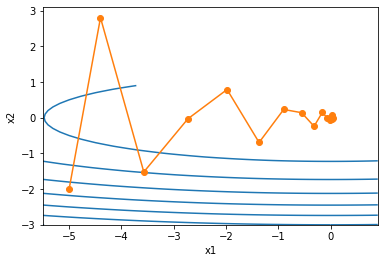

In [ ]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
plot_trace_2d(f, train_2d(momentum_2d))

As we can see, even with the same learning rate that we used before, momentum still converges well. Let us see what happens when we decrease the momentum parameter. Halving it to $\beta = 0.25$ leads to a trajectory that barely converges at all. Nonetheless, it is a lot better than without momentum (when the solution diverges).


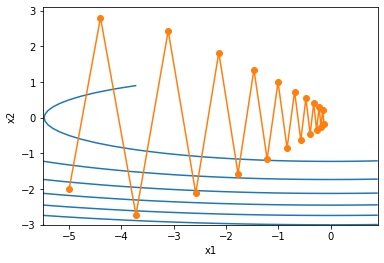

In [ ]:
eta, beta = 0.6, 0.25
plot_trace_2d(f, train_2d(momentum_2d))

Note that we can combine momentum with SGD and in particular, minibatch-SGD. The only change is that in that case we replace the gradients $\mathbf{g}_{t, t-1}$ with $\mathbf{g}_t$. Last, for convenience we initialize $\mathbf{v}_0 = 0$ at time $t=0$. Let us look at what leaky averaging actually does to the updates.

### Effective Sample Weight

Recall that $\mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1}$. In the limit the terms add up to $\sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta}$. In other words, rather than taking a step of size $\eta$ in GD or SGD we take a step of size $\frac{\eta}{1-\beta}$ while at the same time, dealing with a potentially much better behaved descent direction. These are two benefits in one. To illustrate how weighting behaves for different choices of $\beta$ consider the diagram below.


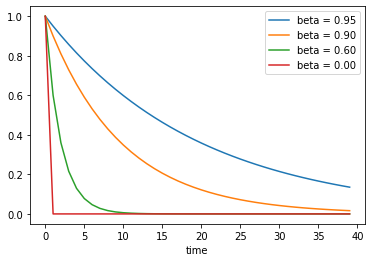

In [ ]:
#set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40)
    plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
plt.xlabel('time')
plt.legend();

## Practical Experiments

Let us see how momentum works in practice, i.e., when used within the context of a proper optimizer. For this we need a somewhat more scalable implementation.

### Implementation from Scratch

Compared with (minibatch) SGD the momentum method needs to maintain a set of  auxiliary variables, i.e., velocity. It has the same shape as the gradients (and variables of the optimization problem). In the implementation below we call these variables `states`.


In [ ]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

In [ ]:
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

Let us see how this works in practice.


In [ ]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)  # Sum of losses, no. of examples
    for X, y in data_iter:
        out = net(X)
        y = d2l.reshape(y, out.shape)
        l = loss(out, y)
        metric.add(d2l.reduce_sum(l), d2l.size(l))
    return metric[0] / metric[1]

In [ ]:
def train(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss # y_hat = wX + b, loss = MSE
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]

            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()

    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.244, 0.020 sec/epoch


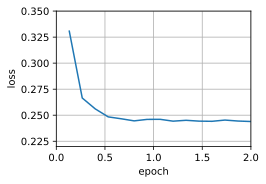

In [ ]:
def train_momentum(lr, momentum, num_epochs=2):
    train(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

When we increase the momentum hyperparameter `momentum` to 0.9, it amounts to a significantly larger effective sample size of $\frac{1}{1 - 0.9} = 10$. We reduce the learning rate slightly to $0.01$ to keep matters under control.


loss: 0.247, 0.016 sec/epoch


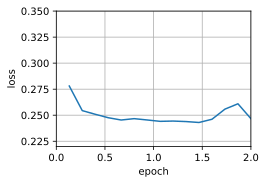

In [ ]:
train_momentum(0.01, 0.9)

Reducing the learning rate further addresses any issue of non-smooth optimization problems. Setting it to $0.005$ yields good convergence properties.


loss: 0.245, 0.016 sec/epoch


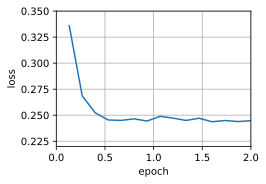

In [ ]:
train_momentum(0.005, 0.9)

### Concise Implementation

There is very little to do in Gluon since the standard `sgd` solver already had momentum built in. Setting matching parameters yields a very similar trajectory.


In [ ]:
# showing (but not using) the source code here since the library functions 
# of d2l are kind of opaque
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)
    net.apply(init_weights)
    
    optimizer = trainer_fn(net.parameters(), **hyperparams)
    
    loss = nn.MSELoss()
    # Note: L2 Loss = 1/2 * MSE Loss. PyTorch has MSE Loss which is slightly
    # different from MXNet's L2Loss by a factor of 2. Hence we halve the loss 
    # value to get L2Loss in PyTorch.
    
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)/2
            l.backward()
            optimizer.step()
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss)/2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.avg():.3f} sec/epoch')

loss: 0.251, 0.017 sec/epoch


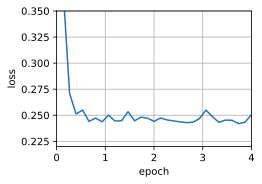

In [ ]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

## Theoretical Analysis

So far the 2D example of $f(x) = 0.1 x_1^2 + 2 x_2^2$ seemed rather contrived. We will now see that this is actually quite representative of the types of problem one might encounter, at least in the case of minimizing convex quadratic objective functions.

### Quadratic Convex Functions

Consider the function

$$h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b.$$

This is a general quadratic function. For positive definite matrices $\mathbf{Q} \succ 0$, i.e., for matrices with positive eigenvalues this has a minimizer at $\mathbf{x}^* = -\mathbf{Q}^{-1} \mathbf{c}$ with minimum value $b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$. Hence we can rewrite $h$ as

$$h(\mathbf{x}) = \frac{1}{2} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})^\top \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c}) + b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}.$$

The gradient is given by $\partial_{\mathbf{x}} f(\mathbf{x}) = \mathbf{Q} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$. That is, it is given by the distance between $\mathbf{x}$ and the minimizer, multiplied by $\mathbf{Q}$. Consequently also the momentum  is a linear combination of terms $\mathbf{Q} (\mathbf{x}_t - \mathbf{Q}^{-1} \mathbf{c})$.

Since $\mathbf{Q}$ is positive definite it can be decomposed into its eigensystem via $\mathbf{Q} = \mathbf{O}^\top \boldsymbol{\Lambda} \mathbf{O}$ for an orthogonal (rotation) matrix $\mathbf{O}$ and a diagonal matrix $\boldsymbol{\Lambda}$ of positive eigenvalues. This allows us to perform a change of variables from $\mathbf{x}$ to $\mathbf{z} := \mathbf{O} (\mathbf{x} - \mathbf{Q}^{-1} \mathbf{c})$ to obtain a much simplified expression:

$$h(\mathbf{z}) = \frac{1}{2} \mathbf{z}^\top \boldsymbol{\Lambda} \mathbf{z} + b'.$$

Here $c' = b - \frac{1}{2} \mathbf{c}^\top \mathbf{Q}^{-1} \mathbf{c}$. Since $\mathbf{O}$ is only an orthogonal matrix this does not perturb the gradients in a meaningful way. Expressed in terms of $\mathbf{z}$ gradient descent becomes

$$\mathbf{z}_t = \mathbf{z}_{t-1} - \boldsymbol{\Lambda} \mathbf{z}_{t-1} = (\mathbf{I} - \boldsymbol{\Lambda}) \mathbf{z}_{t-1}.$$

The important fact in this expression is that gradient descent *does not mix* between different eigenspaces. That is, when expressed in terms of the eigensystem of $\mathbf{Q}$ the optimization problem proceeds in a coordinate-wise manner. This also holds for momentum.

$$\begin{aligned}
\mathbf{v}_t & = \beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1} \\
\mathbf{z}_t & = \mathbf{z}_{t-1} - \eta \left(\beta \mathbf{v}_{t-1} + \boldsymbol{\Lambda} \mathbf{z}_{t-1}\right) \\
    & = (\mathbf{I} - \eta \boldsymbol{\Lambda}) \mathbf{z}_{t-1} - \eta \beta \mathbf{v}_{t-1}.
\end{aligned}$$

In doing this we just proved the following theorem: Gradient Descent with and without momentum for a convex quadratic function decomposes into coordinate-wise optimization in the direction of the eigenvectors of the quadratic matrix.

### Scalar Functions

Given the above result let us see what happens when we minimize the function $f(x) = \frac{\lambda}{2} x^2$. For gradient descent we have

$$x_{t+1} = x_t - \eta \lambda x_t = (1 - \eta \lambda) x_t.$$

Whenever $|1 - \eta \lambda| < 1$ this optimization converges at an exponential rate since after $t$ steps we have $x_t = (1 - \eta \lambda)^t x_0$. This shows how the rate of convergence improves initially as we increase the learning rate $\eta$ until $\eta \lambda = 1$. Beyond that things diverge and for $\eta \lambda > 2$ the optimization problem diverges.


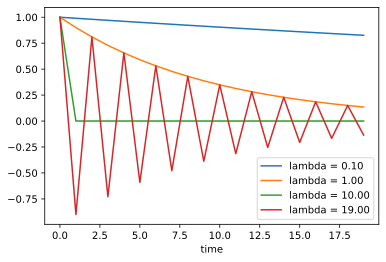

In [ ]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1
#d2l.set_figsize((6, 4))
for lam in lambdas:
    t = np.arange(20)
    plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')
plt.xlabel('time')
plt.legend();

To analyze convergence in the case of momentum we begin by rewriting the update equations in terms of two scalars: one for $x$ and one for the momentum $v$. This yields:

$$
\begin{bmatrix} v_{t+1} \\ x_{t+1} \end{bmatrix} =
\begin{bmatrix} \beta & \lambda \\ -\eta \beta & (1 - \eta \lambda) \end{bmatrix}
\begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix} = \mathbf{R}(\beta, \eta, \lambda) \begin{bmatrix} v_{t} \\ x_{t} \end{bmatrix}.
$$

We used $\mathbf{R}$ to denote the $2 \times 2$ governing convergence behavior. After $t$ steps the initial choice $[v_0, x_0]$ becomes $\mathbf{R}(\beta, \eta, \lambda)^t [v_0, x_0]$. Hence, it is up to the eigenvalues of $\mathbf{R}$ to determine the speed of convergence. See the [Distill post](https://distill.pub/2017/momentum/) of :cite:`Goh.2017` for a great animation and :cite:`Flammarion.Bach.2015` for a detailed analysis. One can show that $0 < \eta \lambda < 2 + 2 \beta$ momentum converges. This is a larger range of feasible parameters when compared to $0 < \eta \lambda < 2$ for gradient descent. It also suggests that in general large values of $\beta$ are desirable. Further details require a fair amount of technical detail and we suggest that the interested reader consult the original publications.

## Summary

* Momentum replaces gradients with a leaky average over past gradients. This accelerates convergence significantly.
* It is desirable for both noise-free gradient descent and (noisy) stochastic gradient descent.
* Momentum prevents stalling of the optimization process that is much more likely to occur for stochastic gradient descent.
* The effective number of gradients is given by $\frac{1}{1-\beta}$ due to exponentiated downweighting of past data.
* In the case of convex quadratic problems this can be analyzed explicitly in detail.
* Implementation is quite straightforward but it requires us to store an additional state vector (momentum $\mathbf{v}$).

## Exercises

1. Use other combinations of momentum hyperparameters and learning rates and observe and analyze the different experimental results.
1. Try out GD and momentum for a quadratic problem where you have multiple eigenvalues, i.e., $f(x) = \frac{1}{2} \sum_i \lambda_i x_i^2$, e.g., $\lambda_i = 2^{-i}$. Plot how the values of $x$ decrease for the initialization $x_i = 1$.
1. Derive minimum value and minimizer for $h(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{x}^\top \mathbf{c} + b$.
1. What changes when we perform SGD with momentum? What happens when we use mini-batch SGD with momentum? Experiment with the parameters?


[Discussions](https://discuss.d2l.ai/t/1070)
